In [23]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('WSNBFSFdataset V2 (1).csv')

TTL = df['TTL']
HopCount = df['Hop_Count']
RateOfEnergyConsumption = df['rate_of_energy_consumption']

# Fitness function
def fitness_function(ind):
    w1, w2, w3 = ind

    if (w1 + w2 + w3) > 1.0:
        return 9999999

    df['risk_score'] = (w1 * RateOfEnergyConsumption) + (w2 * TTL) + (w3 * HopCount)

    if any(df['risk_score'] > 100):
        return 99999999999
    
    if (sum(df['risk_score']) < 50):
        return 99999999999
    
    data = df[df["behaviour"] == 'Under attack']
    
    return data['risk_score'].min()

## Genetic Algorithm

In [3]:
#Creates a random individual
def individual(ind_size, ind_limits):
    ind = []
    for i in range(ind_size):
        ind.append(random.uniform(ind_limits[i][0], ind_limits[i][1]))
    return ind

def crossover(parent1, parent2):
    # Randomly select a crossover point
    point = random.randint(1, len(parent1) - 1)

    # Create the child by mixing genetic information
    child = [0.0] * len(parent1)
    for i in range(len(parent1)):
        if i < point:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]

    # Normalize the child to satisfy the constraint w1 + w2 + w3 = 1
    total = sum(child)
    child = [x / total for x in child]

    return child

In [4]:
#Performs crossover between two parents
def crossover(parent1, parent2):
    if len(parent1) == 1:
        return parent1  # Or you could do some other type of mixing, but with 1 element it's a moot point
    point = random.randint(1, len(parent1) - 1)
    child = parent1[:point] + parent2[point:]
    return child

In [5]:
#Mutates the child
def mutate(child, ind_limits):
    index = random.randint(0, len(child) - 1)
    child[index] = random.uniform(ind_limits[index][0], ind_limits[index][1])
    return child

In [6]:
#Select two parents based on fitness
def select_parents(population, fit_func):
    k = 2
    parent1 = population[0]
    parent2 = min(random.choices(population, k=k), key=fit_func)
    return parent1, parent2

In [7]:
def genetic_algorithm(ind_size, ind_limits, fit_func, pop_size, gen_max):
    population = []
    best_fitnesses = []  # This list will store the best fitness in each generation
    for i in range(pop_size):
        population.append(individual(ind_size, ind_limits))
    for gen in range(gen_max):
        population.sort(key=fit_func)
        best_fitness = fit_func(population[0])  # Take the best individual's fitness
        best_fitnesses.append(best_fitness)  # Add the best fitness to the list
        parent1, parent2 = select_parents(population, fit_func)

        child = crossover(parent1, parent2)
        child = mutate(child, ind_limits)

        # Replace the least fit individual
        population[-1] = child

    # Printing the best individual results for the final results
    best_individual = population[0]

    return best_individual, best_fitnesses

## PSO Algorithm

In [8]:
def particle(ind_size, ind_limits):
    ind = []
    for i in range(ind_size):
        value = random.uniform(ind_limits[i][0], ind_limits[i][1])
        ind.append(value)
    return ind

In [9]:
# Update velocity
def update_velocity(velocity, pBest_position, gBest_position, particle_position, w, c1, c2):
    new_velocity = []
    for i in range(len(velocity)):
        r1, r2 = random.random(), random.random()
        v = w * velocity[i] + c1 * r1 * (pBest_position[i] - particle_position[i]) + c2 * r2 * (gBest_position[i] - particle_position[i])
        new_velocity.append(v)
    return new_velocity

In [10]:
# Update position
def update_position(particle_position, velocity):
    new_position = []
    for i in range(len(particle_position)):
        pos = particle_position[i] + velocity[i]
        # Ensure positions are within limits
        pos = max(0, min(1, pos))
        new_position.append(pos)
    return new_position

In [11]:
# PSO algorithm
def particle_swarm_optimization(ind_size, ind_limits, fit_func, num_particles, num_iterations):
    w, c1, c2 = 0.1, 0.5, 0.5

    particles = [particle(ind_size, ind_limits) for _ in range(num_particles)]
    velocities = [[random.uniform(-1, 1) for _ in range(ind_size)] for _ in range(num_particles)]

    pBests = particles[:]
    gBest = min(pBests, key=fit_func)
    best_fitnesses = []

    for _ in range(num_iterations):
        for i in range(num_particles):
            # Update personal best
            if fit_func(particles[i]) < fit_func(pBests[i]):
                pBests[i] = particles[i]

            # Update global best
            if fit_func(particles[i]) < fit_func(gBest):
                gBest = particles[i]

            velocities[i] = update_velocity(velocities[i], pBests[i], gBest, particles[i], w, c1, c2)
            particles[i] = update_position(particles[i], velocities[i])

        best_fitness = fit_func(gBest)
        best_fitnesses.append(best_fitness)

    return gBest, best_fitnesses

## Running and Plotting

In [12]:
def run_algorithms_and_plot(NUM_RUNS, IND_LIMITS, IND_SIZE, pop_size, gen_max, num_particles, num_iterations):
    # Data collection for line chart
    line_data_GA = []
    line_data_PSO = []
    best_fitnesses_all_iterations_GA = []
    best_fitnesses_all_iterations_PSO = []

    best_solution_GA = None
    best_fitness_GA = float('inf')
    best_run_GA = None
    best_gen_GA = None

    best_solution_PSO = None
    best_fitness_PSO = float('inf')
    best_run_PSO = None
    best_iter_PSO = None

    print("Starting GA runs...")
    # Run GA NUM_RUNS times
    for i in range(NUM_RUNS):
        print("\rRunning GA iteration", i+1,NUM_RUNS, end='')
        best_solution, fitness_over_time = genetic_algorithm(IND_SIZE, IND_LIMITS, fitness_function, pop_size, gen_max)
        line_data_GA.append(fitness_over_time)
        best_fitnesses_all_iterations_GA.append(fitness_function(best_solution))
        if fitness_function(best_solution) < best_fitness_GA:
          best_fitness_GA = fitness_function(best_solution)
          best_solution_GA = best_solution
          best_run_GA = i
          best_gen_GA = np.argmin(fitness_over_time)
    print("\nGA runs completed.")
    # Average the fitness over all runs for GA
    avg_line_data_GA = np.mean(line_data_GA, axis=0)
    print("\n\nStarting PSO runs...")
    # Run PSO NUM_RUNS times
    for i in range(NUM_RUNS):
        print("\rRunning PSO iteration", i+1,NUM_RUNS, end='')
        best_particle, fitness_over_time = particle_swarm_optimization(IND_SIZE, IND_LIMITS, fitness_function, num_particles, num_iterations)
        best_fitnesses_all_iterations_PSO.append(fitness_function(best_particle))
        line_data_PSO.append(fitness_over_time)
        if fitness_function(best_particle) < best_fitness_PSO:
           best_fitness_PSO = fitness_function(best_particle)
           best_solution_PSO = best_particle
           best_run_PSO = i
           best_iter_PSO = np.argmin(fitness_over_time)

    print("\nPSO runs completed.\n\n")
    # Average the fitness over all runs for PSO
    avg_line_data_PSO = np.mean(line_data_PSO, axis=0)

# Plotting
    fig1, ax1 = plt.subplots(figsize=(15, 7))
# Line chart for GA and PSO
    plt.plot(avg_line_data_GA, label="GA")
    plt.plot(avg_line_data_PSO, label="PSO")
    plt.title('Generation/Iteration vs. Average Fitness')
    plt.xlabel('Generation/Iteration')
    plt.ylabel('Average Fitness Value')
    plt.legend()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(15, 7)) # you can adjust this size
    box = plt.boxplot([best_fitnesses_all_iterations_GA, best_fitnesses_all_iterations_PSO],
                  labels=['GA', 'PSO'], patch_artist=True, widths=0.3)
    colors = ['cyan', 'pink']
    for patch, color in zip(box['boxes'], colors):
      patch.set_facecolor(color)
    #plt.xlim(0.3, 2.7)
    plt.gca().set_position([0.1, 0.1, 0.8, 0.8])
    plt.title('Boxplot of Best Fitnesses for Each Iteration')
    plt.ylabel('Fitness Value')
    plt.subplots_adjust(wspace=0.7)  # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()


    print("GA: Best solution is",best_solution_GA, "with fitness ",best_fitness_GA,"Found at run", best_run_GA + 1, "and generation ",best_gen_GA + 1)
    print("PSO: Best solution is", best_solution_PSO, "with fitness", best_fitness_PSO, "Found at run",best_run_PSO + 1, "and iteration",best_iter_PSO + 1)

Starting GA runs...
Running GA iteration 30 30
GA runs completed.


Starting PSO runs...
Running PSO iteration 30 30
PSO runs completed.




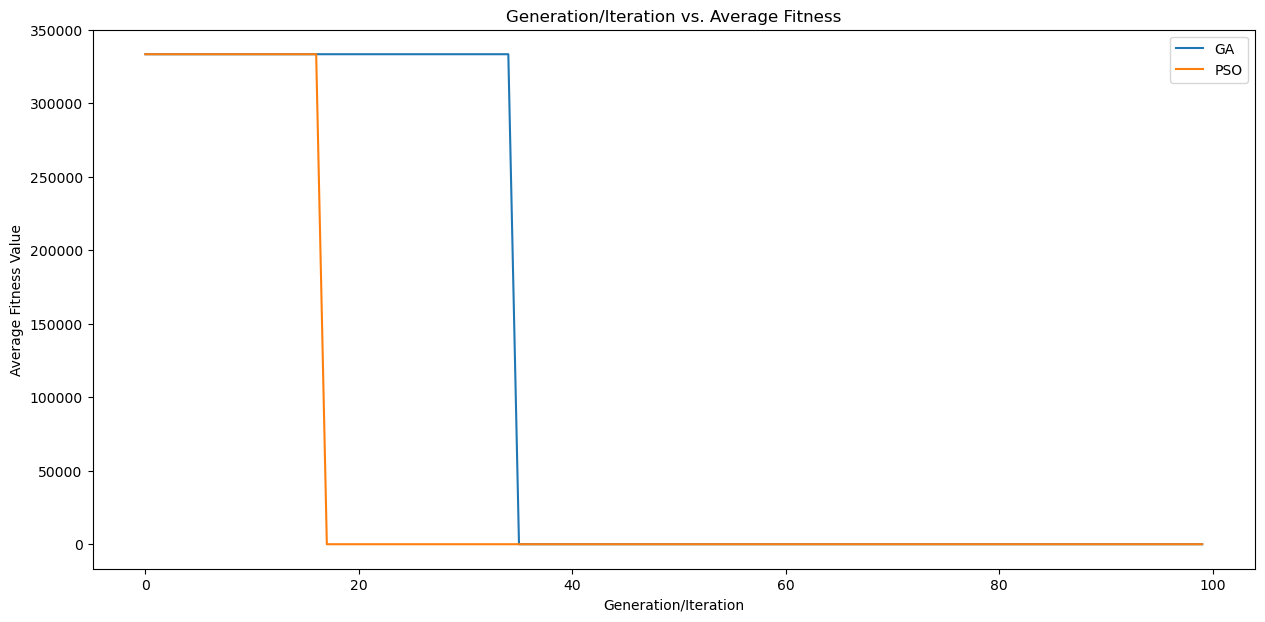

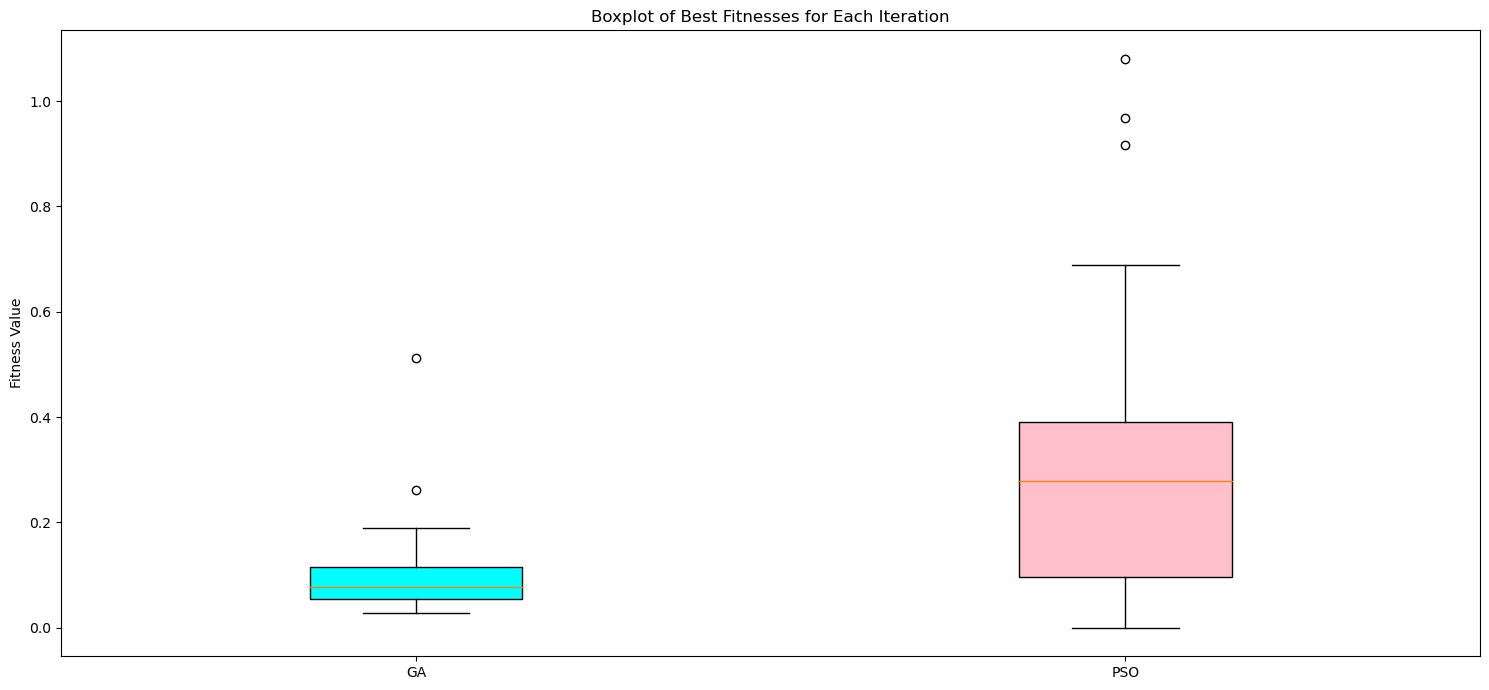

GA: Best solution is [0.21380147064672184, 0.02933685738166747, 0.004767357733436173] with fitness  0.028604146400617037 Found at run 12 and generation  81
PSO: Best solution is [0.2801431175762241, 0.5062918324170067, 0] with fitness 0.0 Found at run 11 and iteration 2


In [13]:
# Setting the algorithm parameters
NUM_RUNS = 30

IND_LIMITS = [(0, 1), (0, 1), (0, 1)]
IND_SIZE = 3

pop_size = 20
num_particles = 20

gen_max = 100
num_iterations = 100

# Running the algorithms and plotting
run_algorithms_and_plot(NUM_RUNS, IND_LIMITS, IND_SIZE, pop_size, gen_max, num_particles, num_iterations)

In [5]:
df = pd.read_csv('WSNBFSFdataset V2 (1).csv')

TTL = df['TTL']
HopCount = df['Hop_Count']
RateOfEnergyConsumption = df['rate_of_energy_consumption']

weights = [0.2801431175762241, 0.5062918324170067, 0]

df['risk_score'] = (weights[0] * RateOfEnergyConsumption) + (weights[1] * TTL) + (weights[2] * HopCount)

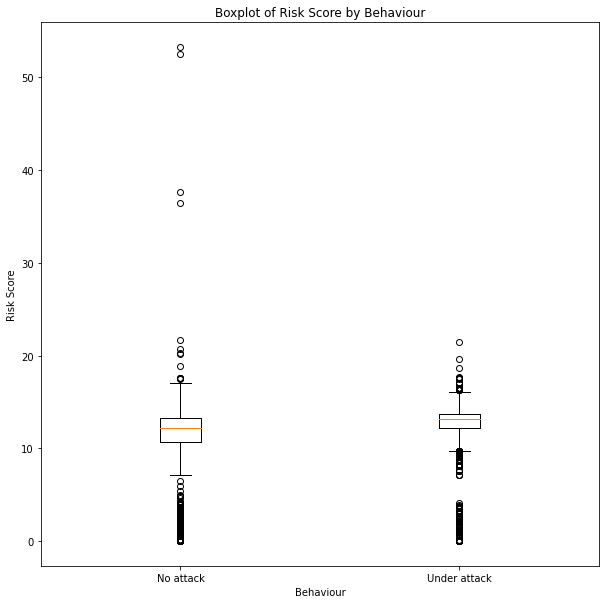

In [89]:
no_attack = df[df['behaviour'] == "No attack"]['risk_score']
under_attack = df[df['behaviour'] == "Under attack"]['risk_score']

labels = ['No attack', 'Under attack']

plt.figure(figsize=(10, 10))
plt.boxplot([no_attack,under_attack ], labels=labels)

plt.xlabel('Behaviour')
plt.ylabel('Risk Score')
plt.title('Boxplot of Risk Score by Behaviour')

plt.show()

In [90]:
df[df['behaviour'] == "Under attack"]['risk_score'].describe()

count    49255.000000
mean        12.619107
std          2.234877
min          0.000000
25%         12.151004
50%         13.163588
75%         13.751560
max         21.434502
Name: risk_score, dtype: float64

In [93]:
df[df['risk_score'] > 12.151004]['behaviour'].value_counts()

No attack       132227
Under attack     36634
Name: behaviour, dtype: int64

In [99]:
df['behaviour'].value_counts()

No attack       262851
Under attack     49255
Name: behaviour, dtype: int64

In [107]:
print("Percentage of Nodes Classified as 'At Risk' when the risk score is > 12.151004: ",(df[df['risk_score'] > 12.151004]['behaviour'].value_counts()[1])/(df[df['risk_score'] > 12.151004]['behaviour'].value_counts()[1] + df[df['risk_score'] > 12.151004]['behaviour'].value_counts()[0]) * 100)
print("Percentage of Underattacks Captured when the risk score is > 12.151004: ",df[df['risk_score'] > 12.151004]['behaviour'].value_counts()[1]/df['behaviour'].value_counts()[1] * 100)

Percentage of Nodes Classified as 'At Risk' when the risk score is > 12.151004:  21.694766701606646
Percentage of Underattacks Captured when the risk score is > 12.151004:  74.37620546137448


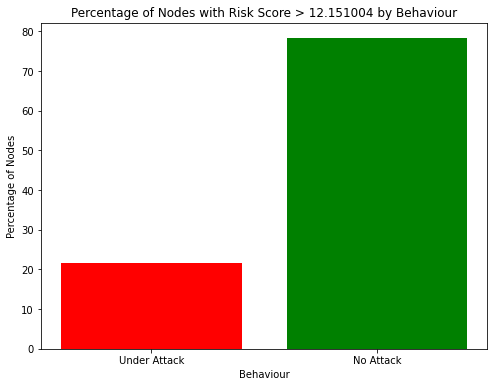

In [106]:
filtered_df = df[df['risk_score'] > 12.151004]

percentage_under_attack = (len(filtered_df[filtered_df['behaviour'] == 'Under attack']) / len(filtered_df)) * 100
percentage_no_attack = (len(filtered_df[filtered_df['behaviour'] == 'No attack']) / len(filtered_df)) * 100

plt.figure(figsize=(8, 6))
plt.bar(['Under Attack', 'No Attack'], [percentage_under_attack, percentage_no_attack], color=['red', 'green'])

plt.xlabel('Behaviour')
plt.ylabel('Percentage of Nodes')
plt.title('Percentage of Nodes with Risk Score > 12.151004 by Behaviour')

plt.show()

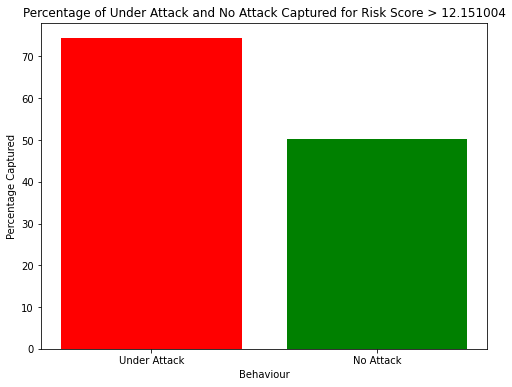

In [109]:
filtered_df = df[df['risk_score'] > 12.151004]

percentage_under_attack_captured = (len(filtered_df[filtered_df['behaviour'] == 'Under attack']) / len(df[df['behaviour'] == 'Under attack'])) * 100
percentage_no_attack_captured = (len(filtered_df[filtered_df['behaviour'] == 'No attack']) / len(df[df['behaviour'] == 'No attack'])) * 100

plt.figure(figsize=(8, 6))
categories = ['Under Attack', 'No Attack']
percentages = [percentage_under_attack_captured, percentage_no_attack_captured]
colors = ['red', 'green']

plt.bar(categories, percentages, color=colors)

plt.xlabel('Behaviour')
plt.ylabel('Percentage Captured')
plt.title('Percentage of Under Attack and No Attack Captured for Risk Score > 12.151004')

plt.show()

In [29]:
df[df['risk_score'] > 17]['behaviour'].value_counts()

No attack       22
Under attack    15
Name: behaviour, dtype: int64

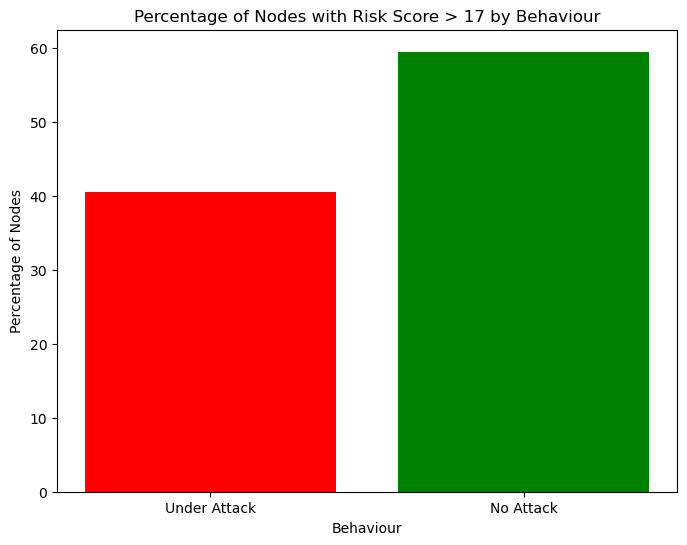

In [32]:
filtered_df = df[df['risk_score'] > 17]

percentage_under_attack = (len(filtered_df[filtered_df['behaviour'] == 'Under attack']) / len(filtered_df)) * 100
percentage_no_attack = (len(filtered_df[filtered_df['behaviour'] == 'No attack']) / len(filtered_df)) * 100

plt.figure(figsize=(8, 6))
plt.bar(['Under Attack', 'No Attack'], [percentage_under_attack, percentage_no_attack], color=['red', 'green'])

plt.xlabel('Behaviour')
plt.ylabel('Percentage of Nodes')
plt.title('Percentage of Nodes with Risk Score > 17 by Behaviour')

plt.show()

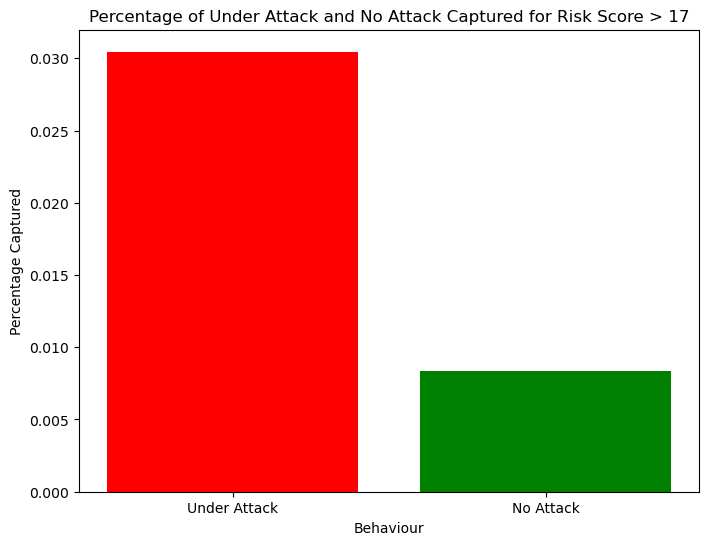

In [33]:
filtered_df = df[df['risk_score'] > 17]

percentage_under_attack_captured = (len(filtered_df[filtered_df['behaviour'] == 'Under attack']) / len(df[df['behaviour'] == 'Under attack'])) * 100
percentage_no_attack_captured = (len(filtered_df[filtered_df['behaviour'] == 'No attack']) / len(df[df['behaviour'] == 'No attack'])) * 100

plt.figure(figsize=(8, 6))
categories = ['Under Attack', 'No Attack']
percentages = [percentage_under_attack_captured, percentage_no_attack_captured]
colors = ['red', 'green']

plt.bar(categories, percentages, color=colors)

plt.xlabel('Behaviour')
plt.ylabel('Percentage Captured')
plt.title('Percentage of Under Attack and No Attack Captured for Risk Score > 17')

plt.show()